In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime

# use of metrics from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("/Users/gaurav/Downloads/ct_rr.csv")

In [4]:
# see the shape of the dataset
df.shape

(8381556, 6)

In [5]:
df.head()

,ts,number,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,14626,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,85490,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,05408,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,58940,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,05408,12.899490,77.587270,12.934780,77.569950


### Basic preprocessing

In [6]:
# 1. Check for any null values
df.isnull().values.any()

False

In [7]:
# So no null values are present in the dataset

In [8]:
# 2. Check for any duplicate values
df[df.duplicated()].shape

(65698, 6)

In [9]:
# drop the duplicates from the dataset, keeping the first non-duplicate
# value

In [10]:
df.drop_duplicates(keep='first', inplace=True)

In [11]:
# shape of df after dropping the duplicates
df.shape

(8315858, 6)

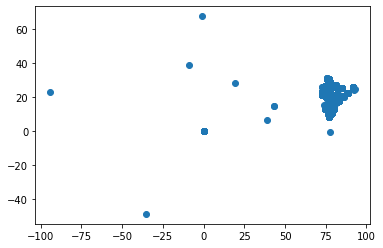

In [12]:
# Analysis of the pickup latitude and longitude
plt.scatter(x=df["pick_lng"], y=df["pick_lat"])
plt.show()

In [13]:
# Few points seems like to be outliers, rest of them form
# the shape of India, probably can drop the extremes

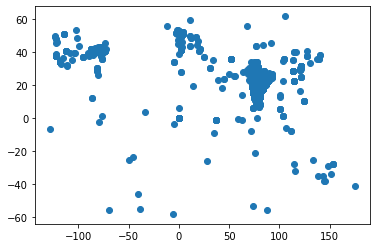

In [14]:
# Analysis of drop latitude and longitude
plt.scatter(x=df["drop_lng"], y=df["drop_lat"])
plt.show()

In [15]:
# Got India's minimum and maximum longitudes
# from https://en.wikipedia.org/wiki/Geography_of_India
min_lat, max_lat = 8.4, 37.6
min_lng, max_lng = 68.7, 97.25

In [16]:
# data-points with either pickup-point of drop-point out of India
df_out_india = df[(df["drop_lat"] < min_lat) | (df["drop_lat"] > max_lat)
               | (df["drop_lng"] < min_lng) | (df["drop_lng"] > max_lng)
               | (df["pick_lat"] < min_lat) | (df["pick_lat"] > max_lat)
               | (df["pick_lng"] < min_lng) | (df["pick_lng"] > max_lng)]

In [17]:
df_out_india.shape

(2407, 6)

In [18]:
# 2407 rows out of 8381556 rows, we can probably drop them.

In [19]:
df.drop(df_out_india.index, inplace=True)

In [20]:
df.shape

(8313451, 6)

In [21]:
# Unique number of customers
df["number"].nunique()

170385

In [22]:
# Its a pretty big value for the number of customers, we can
# probably drop the 'number' column
# We could have used this for customer specific
# if the number of users weren't too many

In [23]:
df.drop(columns=["number"], inplace=True)

In [24]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950


In [25]:
new = df["ts"].str.split(" ", n=1, expand=True)

df["raw_date"] = new[0]
df["raw_time"] = new[1]

new = df["raw_date"].str.split("-", n=2, expand=True)
df["year"] = new[0]
df["month"] = new[1]
df["date"] = new[2]

In [26]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07


In [27]:
new = df["raw_time"].str.split(":", n=2, expand=True)
df["hour"] = new[0]
df["minute"] = new[1]
# no need to use the seconds?

In [28]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,raw_date,raw_time,year,month,date,hour,minute
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018-04-07,07:07:17,2018,04,07,07,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018-04-07,07:32:27,2018,04,07,07,32
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018-04-07,07:36:44,2018,04,07,07,36
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018-04-07,07:38:00,2018,04,07,07,38
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018-04-07,07:39:29,2018,04,07,07,39


In [29]:
# drop the 'raw_date' and 'raw_time' columns
df.drop(columns=["raw_date", "raw_time"], inplace=True)

In [30]:
df.head()

,ts,pick_lat,pick_lng,drop_lat,drop_lng,year,month,date,hour,minute
0,2018-04-07 07:07:17,12.313621,76.658195,12.287301,76.602280,2018,04,07,07,07
1,2018-04-07 07:32:27,12.943947,77.560745,12.954014,77.543770,2018,04,07,07,32
2,2018-04-07 07:36:44,12.899603,77.587300,12.934780,77.569950,2018,04,07,07,36
3,2018-04-07 07:38:00,12.918229,77.607544,12.968971,77.636375,2018,04,07,07,38
4,2018-04-07 07:39:29,12.899490,77.587270,12.934780,77.569950,2018,04,07,07,39


### Create another column (Feature engineering)

In [31]:
def get_day_series(df):
    df_day = pd.Series(df.groupby(["ts"]).size())
    df_day.index = pd.DatetimeIndex(df_day.index)
    df_day = df_day.resample("1D").apply(np.sum)
    
    return df_day

df_day = get_day_series(df)
df_day.head()

ts
2018-04-07     9328
2018-04-08     5686
2018-04-09    11496
2018-04-10    11100
2018-04-11    12041
Freq: D, dtype: int64

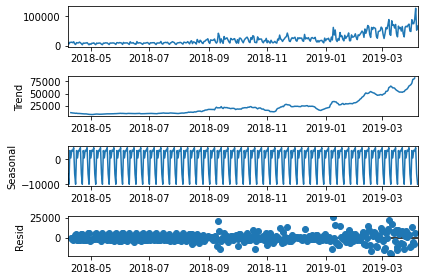

In [32]:
## Trend and Seasonality analysis
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_day, model='additive')

result.plot()
plt.show()

In [33]:
# The above plots show that there is Trend + Seasonality in data

In [34]:
df_day.index.shape

(366,)

In [35]:
Df = pd.DataFrame()
Df['ds'] = df_day.index
Df['y'] = df_day.values

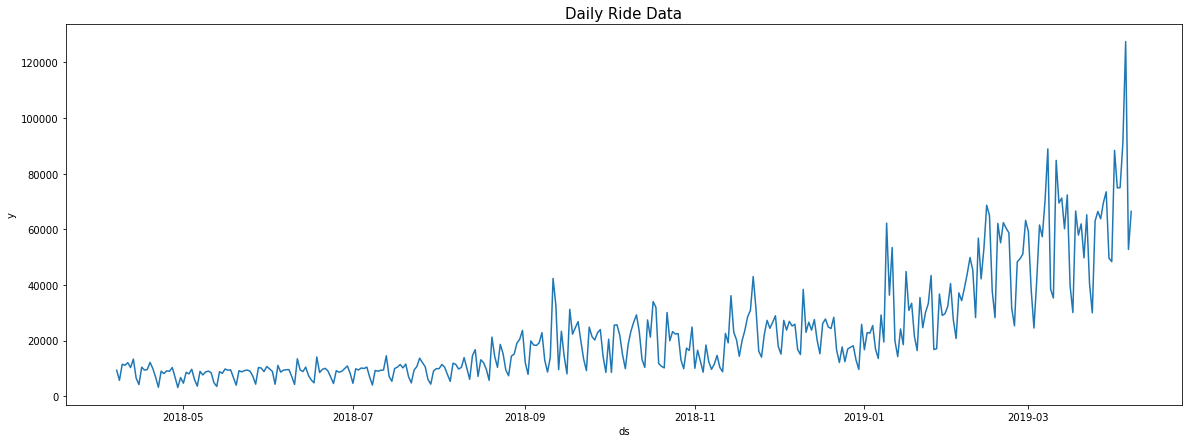

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
a = sns.lineplot(x="ds", y="y", data=Df)
a.set_title("Daily Ride Data", fontsize=15)
plt.show()

In [37]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [38]:
train, test = df_day.iloc[:300], df_day.iloc[300:]

In [39]:
model = ExponentialSmoothing(df_day, seasonal='add',
                             seasonal_periods=7).fit()

In [40]:
pred = model.predict(start=test.index[0], end=test.index[-1])

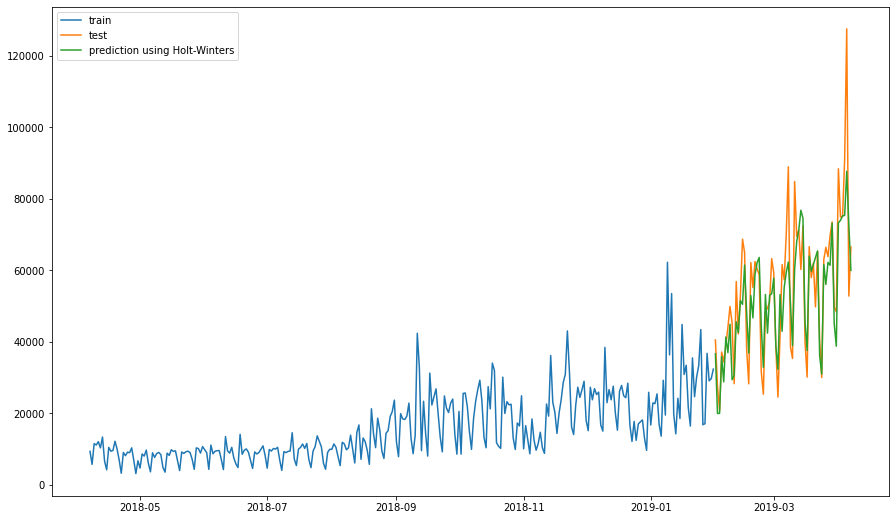

In [41]:
plt.figure(figsize=(15, 9))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(pred.index, pred, label='prediction using Holt-Winters')
plt.legend(loc='best')
plt.show()

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
mae = mean_absolute_error(test, pred)

In [44]:
mae

7410.784426899511

In [45]:
mape = mean_absolute_percentage_error(test, pred)

In [46]:
mape

13.957749085165785